# Exploratory analysis for machine learning algorithm -Random forest- for coral bleaching classification 

## Load dataset

In [3]:
'''
    Import libraries
'''
from sklearn import datasets
import pandas as pd
import numpy as np
import sklearn
import seaborn as sb
import matplotlib.pyplot as plt
from numpy import mean 
from numpy import std
import pingouin as pg
from scipy.stats import shapiro
from scipy.stats import levene 
from scipy.stats import bartlett
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu    
import scikit_posthocs as sp 
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
# check scikit-learn version
print(sklearn.__version__)

0.22.1


In [4]:
'''
    Load full dataset
'''
data = pd.read_csv('df_sst_clouds.csv', low_memory = False)
len(data)

21003

In [3]:
'''
    Subset DF by SEVERITY_CODE [0,1,2,3]
'''
#data = data.dropna() # drop rows that contains NaN's 
data = data[(data.SEVERITY_CODE == 0)|(data.SEVERITY_CODE == 1)|(data.SEVERITY_CODE == 2)|(data.SEVERITY_CODE == 3)] 
#data = data[(data.YEAR >= 2005)] # First year with more than 100 records
#list(data.columns)
data = data.dropna()
len(data)

20263

In [4]:
'''
    ADD colums grouped by SEVERITY CODE combinations
'''
data['SEVERITY_CODE2'] = np.where(data['SEVERITY_CODE']==0, "0","123")
data['SEVERITY_CODE3'] = np.where(data['SEVERITY_CODE']<=1,"01","23")
data['SEVERITY_CODE5'] = np.where(data['SEVERITY_CODE']<=2,"012","3")

In [5]:
# # data = data[data.duplicated(['lat','lon','full_date',
# # 'CF','SST','JD','SEASON','DHW','DAMMM'])]
#data = data.drop_duplicates(['lat','lon','JD','full_date','CF','SST','DHW','WD','CD'])
#data = data.drop(data[(data.DHW == 0) & (data.DHWrunmean7 == 0) & (data.DHWrunmean30 == 0) &(data.DHWrunmean90 == 0) & (data.SEVERITY_CODE > 0)].index) # restricting to cells with an actual DHW value only
data.head(5) 

,ITEM_ID,COUNTRY,lat,lon,SEVERITY_CODE,DHW_class,DAY,MONTH,YEAR,full_date,...,SST_std90_adj_date,CV_run30,CV_run30_adj_date,CV_run7,CV_run7_adj_date,CV_run90,CV_run90_adj_date,SEVERITY_CODE2,SEVERITY_CODE3,SEVERITY_CODE5
0,358,United States,28.1648,-94.2983,1,DHW=0<4,11,10,1993,11-10-1993,...,2.08136,0.023694,0.009149,0.004915,0.010354,0.029244,0.081272,123,01,012
1,384,United States,28.1648,-94.2983,1,DHW=0,14,5,1994,14-5-1994,...,2.01678,0.071154,0.071154,0.021631,0.021631,0.106595,0.106595,123,01,012
2,390,United States,28.1648,-94.2983,0,DHW=0,25,9,1994,25-9-1994,...,2.52363,0.017900,0.016527,0.008298,0.009546,0.017159,0.107526,0,01,012
3,477,United States,28.1648,-94.2983,1,DHW=0,14,5,1995,14-5-1995,...,1.73898,0.052279,0.052279,0.015504,0.015504,0.088814,0.088814,123,01,012
4,495,United States,28.1648,-94.2983,1,DHW=0<4,8,10,1995,8-10-1995,...,1.46104,0.034995,0.014206,0.011881,0.009394,0.029261,0.054517,123,01,012


In [6]:
'''
    Define dataset
'''
X = data.drop(['SEVERITY_CODE','COUNTRY','DAY', 'MONTH','YEAR','JD','lat','lon','full_date','ITEM_ID'], axis=1) # dependent variables
y = data['SEVERITY_CODE'] # labels (indipendent variable)

In [ ]:
'''
    Simple statistical description of variables
'''
var_stats = X.describe()
#var_stats.to_csv('var_desc_stats.csv')
var_stats

In [ ]:
'''
    Define dataset(s) for correllogram DAY of REPORT "dor"
'''
data_dor = data.loc[:, ~data.columns.str.contains('adj')] # select only day of freport
data_dor = data_dor.loc[:, ~data_dor.columns.str.contains('_a')] # drop "CF_a..." variables
X = data_dor.drop(['DHW_class','SEVERITY_CODE','SEVERITY_CODE2','SEVERITY_CODE3', 'COUNTRY', 'DAY', 'MONTH','YEAR','JD','lat','lon','full_date','ITEM_ID','SST_std7','SST_std30','SST_std90'], axis=1) # dependent variables
y = data_dor['SEVERITY_CODE'] # labels (indipendent variable)

In [ ]:
'''
    Correlation plot for date of report
'''
pearsoncorr = X.corr(method='pearson')
#spaermancorr
plt.figure(figsize=(20,15))
sb.heatmap(pearsoncorr, 
            vmin=-1, vmax=1, center=0,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            #annot=True,
            linewidth=0.5,
            fmt='.2g')
#plt.savefig('corr_plot.pdf', dpi=300)
plt.show()

In [ ]:
'''
Pearson significance
'''
from scipy.stats.stats import pearsonr
pval = X.rcorr(stars=False)
pval.to_csv('corr_pval_features.csv')
pval

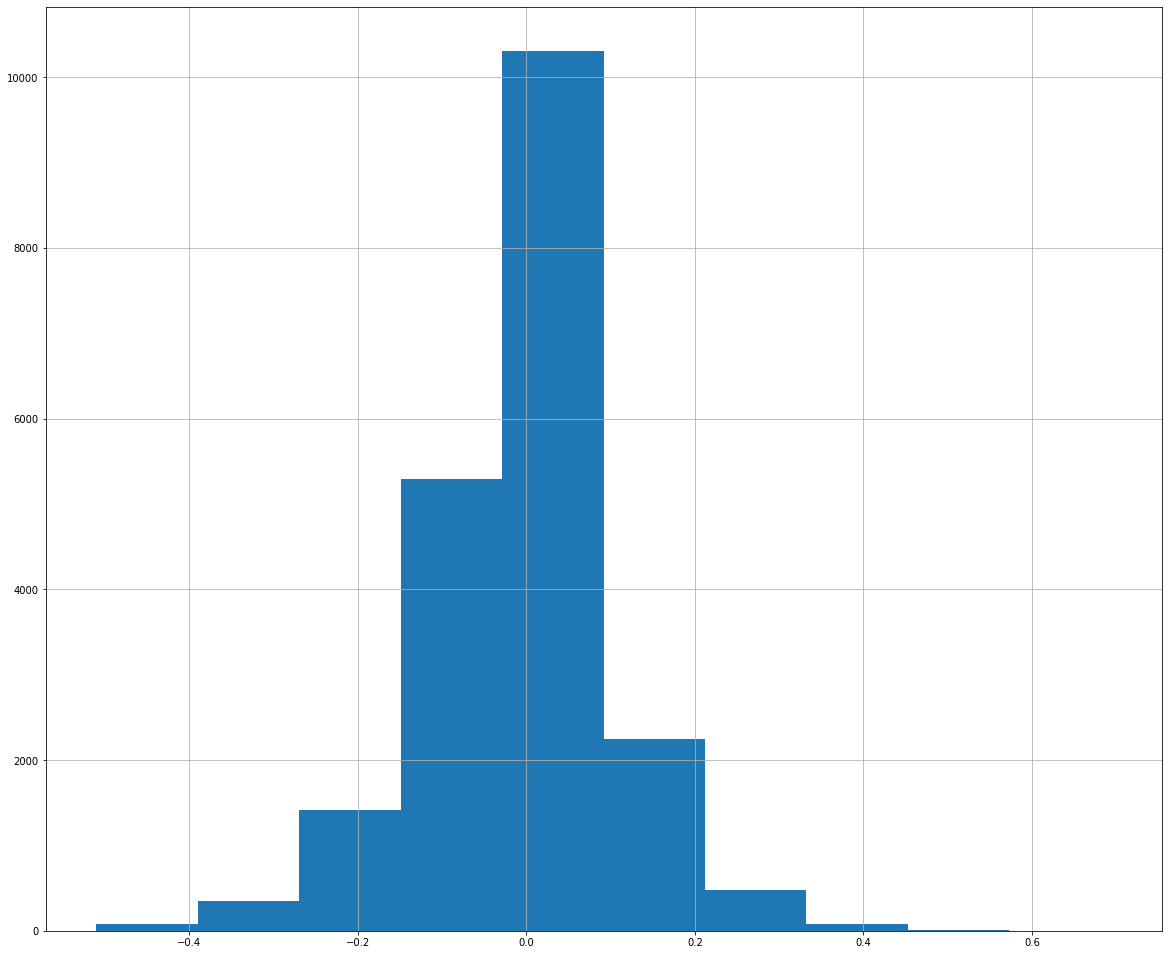

In [17]:
'''
Histogram (all together)
''' 
X['CF_a_runmean30'].hist(figsize=(20,17))
plt.show()
#plt.savefig('General_histograms.pdf', dpi=300)

In [21]:
'''
Normality test
'''
normality = pg.normality(X['CF_a_runmean30'], method='normaltest')
#normality.to_csv('normality_test_features.csv')
from scipy.stats import normaltest
stat, p = normaltest(X['CF_a_runmean30'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1083.713, p=0.000


## Create DF´s grouped by SEVERITY_CODE´s

In [7]:
'''
    Group data by SEVERITY_CODE
    Create four df depending severity level
'''
dfSC0 = data[data['SEVERITY_CODE'] == 0]
dfSC1 = data[data['SEVERITY_CODE'] == 1]
dfSC2 = data[data['SEVERITY_CODE'] == 2]
dfSC3 = data[data['SEVERITY_CODE'] == 3]

'''
    === SEVERITY CODE2 grouped 0 and 1 where "0" = 0 and "1" = 123 ===
'''
dfSC20 = data[data['SEVERITY_CODE2'] == '0']
dfSC21 = data[data['SEVERITY_CODE2'] == '123']

'''
    === SEVERITY CODE3 grouped 0 and 1 where "0" = 01, and "1" = 23 ===
'''
dfSC30 = data[data['SEVERITY_CODE3'] == '01']
dfSC31 = data[data['SEVERITY_CODE3'] == '23']


In [ ]:
data.columns

# 1. How does DHW vary with bleaching severity?

In [ ]:
'''
    Boxplot (general boxplot DHW by SEVERITY_CODE per variable)
     ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='DHW', x='SEVERITY_CODE', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
# DHW_adj_dateboxplot = sb.boxplot(y='DHWrunmean7', x='SEVERITY_CODE', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE')
# plt.show()
# DHWrunmean30boxplot = sb.boxplot(y='DHWrunmean30', x='SEVERITY_CODE', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE')
# plt.show()
# DHWrunmean90_adj_dateboxplot = sb.boxplot(y='DHWrunmean90', x='SEVERITY_CODE', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE')
plt.show()

In [ ]:
'''
       Shapiro-Wilks or normaltest
         ** test for normality ** 
'''
stats, p = shapiro(dfSC0.DHW)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC0.DHWrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC0.DHWrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC0.DHWrunmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfSC1.DHW)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC1.DHWrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC1.DHWrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC1.DHWrunmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfSC2.DHW)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC2.DHWrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC2.DHWrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC2.DHWrunmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfSC3.DHW)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC3.DHWrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC3.DHWrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC3.DHWrunmean90)
print(stats)
print(p)
print("")


In [ ]:
'''
            Levene Test
    ** test for equal variances ** 
'''
stats, p = levene(dfSC0.DHWrunmean7,dfSC1.DHWrunmean7,dfSC2.DHWrunmean7,dfSC3.DHWrunmean7)
print(stats)
print(p)

In [ ]:
from scipy.stats import f_oneway
aov = f_oneway(dfSC0.DHW,dfSC1.DHW,dfSC2.DHW,dfSC3.DHW)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=data['CF_a_runmean30'],
                          groups=data['SEVERITY_CODE'],
                          alpha=0.05)

print("                     ANOVA             ")
print(aov)
print(" ")
print("                 Tukey post-hoc        ")
print(tukey)

In [ ]:
'''
                            Kruskal Wallis
    ** Compare if differences between groups by SEVERITY_CODE **
'''
SC_DHW_Kruskal = stats.kruskal(dfSC0.DHW,dfSC1.DHW,dfSC2.DHW,dfSC3.DHW, nan_policy='omit')
# SC_DHW_9_Kruskal = stats.kruskal(dfSC0.DHW_9,dfSC1.DHW_9,dfSC2.DHW_9,dfSC3.DHW_9, nan_policy='omit')
# SC_DHWrunmean7_Kruskal = stats.kruskal(dfSC0.DHWrunmean7,dfSC1.DHWrunmean7,dfSC2.DHWrunmean7,dfSC3.DHWrunmean7, nan_policy='omit')
# SC_DHWrunmean30_Kruskal = stats.kruskal(dfSC0.DHWrunmean30,dfSC1.DHWrunmean30,dfSC2.DHWrunmean30,dfSC3.DHWrunmean30, nan_policy='omit')
# kruskal_test = stats.kruskal(dfSC20.DHW,dfSC21.DHW, nan_policy='omit')
print(SC_DHW_Kruskal)
# print(SC_DHW_9_Kruskal)
# print(SC_DHWrunmean30_Kruskal)
# print(SC_DHWrunmean7_Kruskal)
# print(kruskal_test)


In [ ]:
'''
         Dunn post_hoc test
    ** Which group is different **
'''
DHW_dunn = sp.posthoc_dunn(data, 'DHW', 'SEVERITY_CODE', 'bonferroni')
DHW_9_dunn = sp.posthoc_dunn(data, 'DHW_9', 'SEVERITY_CODE', 'bonferroni')
DHWrunmean7_dunn = sp.posthoc_dunn(data, 'DHWrunmean7', 'SEVERITY_CODE', 'bonferroni')
DHWrunmean30_dunn = sp.posthoc_dunn(data, 'DHWrunmean30', 'SEVERITY_CODE', 'bonferroni')
print('DHW_dunn')
print(DHW_dunn)
# print('DHW_9_dunn')
# print(DHW_9_dunn)
# print('DHWrunmean7_dunn')
# print(DHWrunmean7_dunn)
# print('DHWrunmean30_dunn')
# print(DHWrunmean30_dunn)

In [ ]:
'''
    Boxplot (general boxplot DHW by SEVERITY_CODE2 per variable)
     ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='DHW', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2')
plt.show()
DHW_adj_dateboxplot = sb.boxplot(y='DHWrunmean7', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2')
plt.show()
DHWrunmean30boxplot = sb.boxplot(y='DHWrunmean30', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2')
plt.show()
DHWrunmean30_adj_dateboxplot = sb.boxplot(y='DHWrunmean90', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2')
plt.show()

In [ ]:
'''
    In this case there are only two groups, so it can be either KW or MWu
                            Kruskal Wallis
    ** Compare if differences between groups by SEVERITY_CODE2 **
'''
SC2_DHW_Kruskal = stats.kruskal(dfSC20.DHW,dfSC21.DHW, nan_policy='omit')
SC2_DHW_9_Kruskal = stats.kruskal(dfSC20.DHW_9,dfSC21.DHW_9, nan_policy='omit')
SC2_DHWrunmean7_Kruskal = stats.kruskal(dfSC20.DHWrunmean7,dfSC21.DHWrunmean7, nan_policy='omit')
SC2_DHWrunmean30_Kruskal = stats.kruskal(dfSC20.DHWrunmean30,dfSC21.DHWrunmean30, nan_policy='omit')
SC2_DHWrunmean90_Kruskal = stats.kruskal(dfSC20.DHWrunmean90,dfSC21.DHWrunmean90, nan_policy='omit')
print(SC2_DHW_Kruskal)
print(SC2_DHW_9_Kruskal)
print(SC2_DHWrunmean7_Kruskal)
print(SC2_DHWrunmean30_Kruskal)
print(SC2_DHWrunmean90_Kruskal)

In [ ]:
'''
                Mann Whitney U-Test DHW's SEVERITY_CODE2
'''
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dfSC20.DHW,dfSC21.DHW)
print('Statistics Mann-Whitney U test dfSC20.DHW-dfSC21.DHW =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.DHW_9,dfSC21.DHW_9)
print('Statistics Mann-Whitney U test fSC20.DHW_9-dfSC21.DHW_9 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.DHWrunmean7,dfSC21.DHWrunmean7)
print('Statistics Mann-Whitney U test fSC20.DHWrunmean7-dfSC21.DHWrunmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.DHWrunmean30,dfSC21.DHWrunmean30)
print('Statistics Mann-Whitney U test fSC20.DHWrunmean3-dfSC21.DHWrunmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.DHWrunmean90,dfSC21.DHWrunmean90)
print('Statistics Mann-Whitney U test fSC20.DHWrunmean7-dfSC21.DHWrunmean7 =%.3f, p=%.3f' % (stat, p))

In [ ]:
'''
    Boxplot (general boxplot DHW by SEVERITY_CODE3 per variable)
     ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='DHW', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3')
plt.show()
DHW_adj_dateboxplot = sb.boxplot(y='DHWrunmean7', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3')
plt.show()
DHWrunmean30boxplot = sb.boxplot(y='DHWrunmean30', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3')
plt.show()
DHWrunmean30_adj_dateboxplot = sb.boxplot(y='DHWrunmean90', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3')
plt.show()

In [ ]:
'''
    In this case there are only two groups, so it can be either KW or MWu
                            Kruskal Wallis
    ** Compare if differences between groups by SEVERITY_CODE3 **
'''
SC3_DHW_Kruskal = stats.kruskal(dfSC30.DHW,dfSC31.DHW, nan_policy='omit')
SC3_DHW_9_Kruskal = stats.kruskal(dfSC30.DHW_9,dfSC31.DHW_9, nan_policy='omit')
SC3_DHWrunmean7_Kruskal = stats.kruskal(dfSC30.DHWrunmean7,dfSC31.DHWrunmean7, nan_policy='omit')
SC3_DHWrunmean30_Kruskal = stats.kruskal(dfSC30.DHWrunmean30,dfSC31.DHWrunmean30, nan_policy='omit')
SC3_DHWrunmean90_Kruskal = stats.kruskal(dfSC30.DHWrunmean90,dfSC31.DHWrunmean90, nan_policy='omit')
print(SC3_DHW_Kruskal)
print(SC3_DHW_9_Kruskal)
print(SC3_DHWrunmean7_Kruskal)
print(SC3_DHWrunmean30_Kruskal)
print(SC3_DHWrunmean90_Kruskal)

In [ ]:
'''
                Mann Whitney U-Test DHW's SEVERITY_CODE3
'''
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dfSC30.DHW,dfSC31.DHW)
print('Statistics Mann-Whitney U test dfSC20.DHW-dfSC21.DHW =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.DHW_9,dfSC31.DHW_9)
print('Statistics Mann-Whitney U test fSC20.DHW_9-dfSC21.DHW_9 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.DHWrunmean7,dfSC31.DHWrunmean7)
print('Statistics Mann-Whitney U test fSC20.DHWrunmean7-dfSC21.DHWrunmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.DHWrunmean30,dfSC31.DHWrunmean30)
print('Statistics Mann-Whitney U test fSC20.DHWrunmean3-dfSC21.DHWrunmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.DHWrunmean90,dfSC31.DHWrunmean90)
print('Statistics Mann-Whitney U test fSC20.DHWrunmean7-dfSC21.DHWrunmean7 =%.3f, p=%.3f' % (stat, p))

# 2. How does cloud cover vary with bleaching severity?

In [ ]:
'''
    Boxplot (general boxplot CLOUD COVER by SEVERITY per variable)
        ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
# pal = sb.color_palette('PuBu')
# DHWboxplot = sb.boxplot(y='CF', x='SEVERITY_CODE', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE')
# plt.show()
# DHWrunmean7boxplot = sb.boxplot(y='CFrunmean7', x='SEVERITY_CODE', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE')
# plt.show()
# DHWrunmean30boxplot = sb.boxplot(y='CFrunmean30', x='SEVERITY_CODE', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE')
# plt.show()
DHWrunmean90boxplot = sb.boxplot(y='CFrunmean90', x='SEVERITY_CODE', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()

In [ ]:
'''
       Shapiro-Wilks or normaltest
         ** test for normality ** 
'''
stats, p = shapiro(dfSC0.CFrunmean90)
print(stats)
print(p)
normality = pg.normality(dfSC3.DHW, method='normaltest') # normal test for large dataset
#homoscedasticity = pg.homoscedasticity(data, method='levene') # bartlett 
#normality.to_csv('normality_test_features.csv')

In [ ]:
'''
            Levene Test
    ** test for equal variances ** 
'''
stats, p = levene(dfSC0.CFrunmean90,dfSC1.CFrunmean90,dfSC2.CFrunmean90,dfSC3.CFrunmean90)
print(stats)
print(p)

In [ ]:
'''
                 Kruskal Wallis
    ** Compare if differences between groups **
'''
SC_CF_Kruskal = stats.kruskal(dfSC0.CF,dfSC1.CF,dfSC2.CF,dfSC3.CF, nan_policy='omit')

SC_CFrunmean7_Kruskal = stats.kruskal(dfSC0.CFrunmean7,dfSC1.CFrunmean7,dfSC2.CFrunmean7,dfSC3.CFrunmean7, nan_policy='omit')

SC_CFrunmean30_Kruskal = stats.kruskal(dfSC0.CFrunmean30,dfSC1.CFrunmean30,dfSC2.CFrunmean30,dfSC3.CFrunmean30, nan_policy='omit')

SC_CFrunmean90_Kruskal = stats.kruskal(dfSC0.CFrunmean90,dfSC1.CFrunmean90,dfSC2.CFrunmean90,dfSC3.CFrunmean90, nan_policy='omit')

#print(SC_CF_Kruskal)
print(SC_CFrunmean7_Kruskal)
print(SC_CFrunmean30_Kruskal)
print(SC_CFrunmean90_Kruskal)

In [ ]:
'''
         Dunn post_hoc test
    ** Which group is different **
'''
CF_dunn = sp.posthoc_dunn(data, 'CF', 'SEVERITY_CODE')
CFrunmean7_dunn = sp.posthoc_dunn(data, 'CFrunmean7', 'SEVERITY_CODE')
CFrunmean30_dunn = sp.posthoc_dunn(data, 'CFrunmean30', 'SEVERITY_CODE')
CFrunmean90_dunn = sp.posthoc_dunn(data, 'CFrunmean90', 'SEVERITY_CODE')
print('CF_dunn')
print(CF_dunn)
print('CFrunmean7_dunn')
print(CFrunmean7_dunn)
print('CFrunmean30_dunn')
print(CFrunmean30_dunn)
print('CFrunmean90_dunn')
print(CFrunmean90_dunn)

In [ ]:
'''
    Boxplot (general boxplot CLOUD COVER by SEVERITY2 per variable)
        ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
# DHWboxplot = sb.boxplot(y='CF', x='SEVERITY_CODE2', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE2')
# plt.show()
# DHW_adj_dateboxplot = sb.boxplot(y='CFrunmean7', x='SEVERITY_CODE2', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE2')
# plt.show()
# DHWrunmean30boxplot = sb.boxplot(y='CFrunmean30', x='SEVERITY_CODE2', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE2')
# plt.show()
DHWrunmean90_adj_dateboxplot = sb.boxplot(y='CFrunmean90', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2')
plt.show()

In [ ]:
'''
       Shapiro-Wilks or normaltest 
         ** test for normality ** 
'''
stats, p = shapiro(dfSC20.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC20.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC20.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC20.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC21.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC21.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC21.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC21.CFrunmean90)
print(stats)
print(p)
print("")

In [ ]:
'''
            Levene Test 
    ** test for equal variances ** 
'''
stats, p = levene(dfSC20.CF,dfSC21.CF)
print(stats)
print(p)
print("")
stats, p = levene(dfSC20.CFrunmean7,dfSC21.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = levene(dfSC20.CFrunmean30,dfSC21.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = levene(dfSC20.CFrunmean90,dfSC21.CFrunmean90)
print(stats)
print(p)

In [ ]:
'''
                Mann Whitney U-Test CF's SEVERITY_CODE2
     === SEVERITY CODE2 grouped as 0 and 1 where "0" = 0 and "1" = 123 ===
'''
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dfSC20.CF,dfSC21.CF)
print('Statistics Mann-Whitney U test fSC20.CF-dfSC21.CF =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.CFrunmean7,dfSC21.CFrunmean7)
print('Statistics Mann-Whitney U test fSC20.CFrunmean7-dfSC21.CFrunmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.CFrunmean30,dfSC21.CFrunmean30)
print('Statistics Mann-Whitney U test fSC20.CFrunmean30-dfSC21.CFrunmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.CFrunmean90,dfSC21.CFrunmean90)
print('Statistics Mann-Whitney U test fSC20.CFrunmean90-dfSC21.CFrunmean90 =%.3f, p=%.3f' % (stat, p))

In [ ]:
'''
    Boxplot (general boxplot CLOUD COVER by SEVERITY3 per variable)
        ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
# DHWboxplot = sb.boxplot(y='CF', x='SEVERITY_CODE3', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE3')
# plt.show()
# DHW_adj_dateboxplot = sb.boxplot(y='CFrunmean7', x='SEVERITY_CODE3', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE3')
# plt.show()
# DHWrunmean30boxplot = sb.boxplot(y='CFrunmean30', x='SEVERITY_CODE3', 
#                  data=data, 
#                  palette=pal,
#                  hue='SEVERITY_CODE3')
# plt.show()
DHWrunmean90_adj_dateboxplot = sb.boxplot(y='CFrunmean90', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3')
plt.show()

In [ ]:
'''
       Shapiro-Wilks or normaltest 
         ** test for normality ** 
'''
stats, p = shapiro(dfSC30.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC30.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC30.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC30.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC31.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC31.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC31.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC31.CFrunmean90)
print(stats)
print(p)
print("")

In [ ]:
'''
            Levene Test 
    ** test for equal variances ** 
'''
stats, p = levene(dfSC30.CF,dfSC31.CF)
print(stats)
print(p)
print("")
stats, p = levene(dfSC30.CFrunmean7,dfSC31.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = levene(dfSC30.CFrunmean30,dfSC31.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = levene(dfSC30.CFrunmean90,dfSC31.CFrunmean90)
print(stats)
print(p)

In [ ]:
'''
                    Mann Whitney U-Test CF's SEVERITY_CODE3
       === SEVERITY CODE3 grouped 0 and 1 where "0" = 01, and "1" = 23 ===
'''
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dfSC30.CF,dfSC31.CF)
print('Statistics Mann-Whitney U test dfSC30.CF-dfSC31.CF =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.CFrunmean7,dfSC31.CFrunmean7)
print('Statistics Mann-Whitney U test fSC30.CFrunmean7-dfSC31.CFrunmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.CFrunmean30,dfSC31.CFrunmean30)
print('Statistics Mann-Whitney U test fSC30.CFrunmean30-dfSC31.CFrunmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.CFrunmean90,dfSC31.CFrunmean90)
print('Statistics Mann-Whitney U test fSC90.CFrunmean90-dfSC31.CFrunmean90 =%.3f, p=%.3f' % (stat, p))

In [ ]:
'''
        ===    CF's anomaly SEVERITY_CODE 0 vs 2 + 3  ===
            
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
dfSC2and3 = data[data['SEVERITY_CODE3'] == '23']
dfSC2and3vsSC0 = dfSC2and3.append(dfSC0)
dfSC2and3vsSC0['SEVERITY_CODE6'] = np.where(dfSC2and3vsSC0['SEVERITY_CODE']>=2,"23","0")
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('Paired')
DHWboxplot = sb.violinplot(y='CF_a_runmean90', x='SEVERITY_CODE6', 
                 data=dfSC2and3vsSC0,
                 palette=pal,
                 hue='SEVERITY_CODE6')

stat, p = mannwhitneyu(dfSC2and3vsSC0[dfSC2and3vsSC0.SEVERITY_CODE6 == '23'].CFrunmean90,dfSC2and3vsSC0[dfSC2and3vsSC0.SEVERITY_CODE6 == '0'].CFrunmean90)
print('Statistics Mann-Whitney U test dfSC23.CF_a,dfSC0.CFrunmean =%.3f, p=%.3f' % (stat, p))

# 3. Is cloud cover anomaly a better variable for addressing the previous question?

In [ ]:
'''
    Boxplot (general boxplot CLOUD COVER by SEVERITY per variable)
        ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
CF_a_runmean90boxplot = sb.boxplot(y='CF_a_runmean90', x='SEVERITY_CODE', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()

In [ ]:
'''
       Shapiro-Wilks or normaltest
         ** test for normality ** 
'''
stats, p = shapiro(dfSC0.CF_a)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC1.CF_a)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC2.CF_a)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC3.CF_a)
print(stats)
print(p)
print('')

stats, p = shapiro(dfSC0.CF_a_runmean7)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC1.CF_a_runmean7)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC2.CF_a_runmean7)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC3.CF_a_runmean7)
print(stats)
print(p)
print('')

stats, p = shapiro(dfSC0.CF_a_runmean30)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC1.CF_a_runmean30)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC2.CF_a_runmean30)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC3.CF_a_runmean30)
print(stats)
print(p)
print('')

stats, p = shapiro(dfSC0.CF_a_runmean90)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC1.CF_a_runmean90)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC2.CF_a_runmean90)
print(stats)
print(p)
print('')
stats, p = shapiro(dfSC3.CF_a_runmean90)
print(stats)
print(p)
print('')

In [ ]:
'''
            Levene Test
    ** test for equal variances ** 
'''
stats, p = levene(dfSC0.CF_a_runmean30,dfSC1.CF_a_runmean30,dfSC2.CF_a_runmean30,dfSC3.CF_a_runmean30)
print(stats)
print(p)

In [24]:
'''
                 Kruskal Wallis
    ** Compare if differences between groups **
'''
SC_CF_a_Kruskal = stats.kruskal(dfSC0.CF_a,dfSC1.CF_a,dfSC2.CF_a,dfSC3.CF_a, nan_policy='omit')
SC_CF_a_runmean7_Kruskal = stats.kruskal(dfSC0.CF_a_runmean7,dfSC1.CF_a_runmean7,dfSC2.CF_a_runmean7,dfSC3.CF_a_runmean7, nan_policy='omit')
SC_CF_a_runmean30_Kruskal = stats.kruskal(dfSC0.CFrunmean30,dfSC1.CFrunmean30,dfSC2.CFrunmean30,dfSC3.CFrunmean30, nan_policy='omit')
SC_CF_a_runmean90_Kruskal = stats.kruskal(dfSC0.CF_a_runmean90,dfSC1.CF_a_runmean90,dfSC2.CF_a_runmean90,dfSC3.CF_a_runmean90, nan_policy='omit')

print(SC_CF_a_Kruskal)
print(SC_CF_a_runmean7_Kruskal)
print(SC_CF_a_runmean30_Kruskal)
print(SC_CF_a_runmean90_Kruskal)

KruskalResult(statistic=10.852437194675755, pvalue=0.012551159408493011)
KruskalResult(statistic=18.618849164770047, pvalue=0.0003277696413199426)
KruskalResult(statistic=109.98572924860527, pvalue=1.1051131108403946e-23)
KruskalResult(statistic=213.1393968664208, pvalue=6.104687232143189e-46)


In [25]:
'''
         Dunn post_hoc test
    ** Which group is different **
'''
CF_a_dunn = sp.posthoc_dunn(data, 'CF_a', 'SEVERITY_CODE')
CF_a_runmean7_dunn = sp.posthoc_dunn(data, 'CF_a_runmean7', 'SEVERITY_CODE')
CF_a_runmean30_dunn = sp.posthoc_dunn(data, 'CF_a_runmean30', 'SEVERITY_CODE')
CF_a_runmean90_dunn = sp.posthoc_dunn(data, 'CF_a_runmean90', 'SEVERITY_CODE')
print('CF_a_dunn')
print(CF_a_dunn)
print('CF_a_runmean7_dunn')
print(CF_a_runmean7_dunn)
print('CF_a_runmean30_dunn')
print(CF_a_runmean30_dunn)
print('CF_a_runmean90_dunn')
print(CF_a_runmean90_dunn)

CF_a_dunn
          0         1         2         3
0  1.000000  0.495243  0.012309  0.130115
1  0.495243  1.000000  0.004092  0.052095
2  0.012309  0.004092  1.000000  0.562109
3  0.130115  0.052095  0.562109  1.000000
CF_a_runmean7_dunn
          0         1        2         3
0  1.000000  0.332761  0.32480  0.000300
1  0.332761  1.000000  0.07702  0.000039
2  0.324800  0.077020  1.00000  0.009690
3  0.000300  0.000039  0.00969  1.000000
CF_a_runmean30_dunn
              0             1             2             3
0  1.000000e+00  9.409511e-01  1.139117e-02  1.109469e-15
1  9.409511e-01  1.000000e+00  2.740182e-02  2.180561e-13
2  1.139117e-02  2.740182e-02  1.000000e+00  4.838555e-08
3  1.109469e-15  2.180561e-13  4.838555e-08  1.000000e+00
CF_a_runmean90_dunn
              0             1             2             3
0  1.000000e+00  6.293370e-02  2.517498e-08  1.650072e-45
1  6.293370e-02  1.000000e+00  9.356037e-04  5.177939e-31
2  2.517498e-08  9.356037e-04  1.000000e+00  1.86042

In [ ]:
'''
    Boxplot (general boxplot CLOUD COVER ANOMALY by SEVERITY2 per variable)
            ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='CF_a', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2')
plt.show()
DHW_adj_dateboxplot = sb.boxplot(y='CF_a_runmean7', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2')
plt.show()
DHWrunmean30boxplot = sb.boxplot(y='CF_a_runmean30', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2')
plt.show()
DHWrunmean30_adj_dateboxplot = sb.boxplot(y='CF_a_runmean90', x='SEVERITY_CODE2', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE2',
                 showmeans=True)
plt.show()

In [ ]:
'''
       Shapiro-Wilks or normaltest 
         ** test for normality ** 
'''
stats, p = shapiro(dfSC20.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC20.CF_a_arunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC20.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC20.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC21.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC21.CF_a_arunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC21.CF_a_arunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC21.CF_a_arunmean90)
print(stats)
print(p)
print("")

In [ ]:
'''
            Levene Test 
    ** test for equal variances ** 
'''
stats, p = levene(dfSC20.CF_a,dfSC21.CF_a)
print(stats)
print(p)
print("")
stats, p = levene(dfSC20.CF_a_runmean7,dfSC21.CF_runmean7)
print(stats)
print(p)
print("")
stats, p = levene(dfSC20.CF_a_runmean30,dfSC21.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = levene(dfSC20.CF_a_runmean90,dfSC21.CF_a_runmean90)
print(stats)
print(p)

In [ ]:
'''
                Mann Whitney U-Test CF's SEVERITY_CODE2
     === SEVERITY CODE2 grouped as 0 and 1 where "0" = 0 and "1" = 123 ===
'''

stat, p = mannwhitneyu(dfSC20.CF_a,dfSC21.CF_a)
print('Statistics Mann-Whitney U test fSC20.CF_a-dfSC21.CF_a =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.CF_a_runmean7,dfSC21.CF_a_runmean7)
print('Statistics Mann-Whitney U test fSC20.CF_a_runmean7-dfSC21.CF_a_runmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.CF_a_runmean30,dfSC21.CF_a_runmean30)
print('Statistics Mann-Whitney U test fSC20.CF_a_runmean30-dfSC21.CF_a_runmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC20.CF_a_runmean90,dfSC21.CF_a_runmean90)
print('Statistics Mann-Whitney U test fSC20.CF_a_runmean90-dfSC21.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))

In [ ]:
'''
    Boxplot (general boxplot CLOUD COVER ANOMALY by SEVERITY3 per variable)
            ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='CF_a', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3')
plt.show()
DHW_adj_dateboxplot = sb.boxplot(y='CF_a_runmean7', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3')
plt.show()
DHWrunmean30boxplot = sb.boxplot(y='CF_a_runmean30', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3')
plt.show()
DHWrunmean30_adj_dateboxplot = sb.boxplot(y='CF_a_runmean90', x='SEVERITY_CODE3', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE3',
                 showmeans=True)
plt.show()

In [ ]:
'''
       Shapiro-Wilks or normaltest 
         ** test for normality ** 
'''
stats, p = shapiro(dfSC30.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC30.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC30.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC30.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC31.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC31.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC31.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfSC31.CF_a_runmean90)
print(stats)
print(p)
print("")

In [ ]:
'''
            Levene Test 
    ** test for equal variances ** 
'''
stats, p = levene(dfSC30.CF_a,dfSC31.CF_a)
print(stats)
print(p)
print("")
stats, p = levene(dfSC30.CF_a_runmean7,dfSC31.CF_runmean7)
print(stats)
print(p)
print("")
stats, p = levene(dfSC30.CF_a_runmean30,dfSC31.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = levene(dfSC30.CF_a_runmean90,dfSC31.CF_a_runmean90)
print(stats)
print(p)

In [ ]:
'''
                Mann Whitney U-Test CF's SEVERITY_CODE3
     === SEVERITY CODE2 grouped as 0 and 1 where "0" = 01 and "1" = 23 ===
'''

stat, p = mannwhitneyu(dfSC30.CF_a,dfSC31.CF_a)
print('Statistics Mann-Whitney U test dfSC30.CF_a-dfSC31.CF_a =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.CF_a_runmean7,dfSC31.CF_a_runmean7)
print('Statistics Mann-Whitney U test dfSC30.CF_a_runmean7-dfSC31.CF_a_runmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.CF_a_runmean30,dfSC31.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfSC30.CF_a_runmean3-dfSC31.CF_a_runmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfSC30.CF_a_runmean90,dfSC31.CF_a_runmean90)
print('Statistics Mann-Whitney U test dfSC20.CF_a_runmean7-dfSC21.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))

In [ ]:
'''
        ===    CF's anomaly SEVERITY_CODE 0 vs 2 + 3  ===
            
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
dfSC2and3 = data[data['SEVERITY_CODE3'] == '23']
dfSC2and3vsSC0 = dfSC2and3.append(dfSC0)
#dfSC2and3vsSC0 = dfSC2and3vsSC0[(dfSC2and3vsSC0['DHW_class']=='DHW>8')]
dfSC2and3vsSC0['SEVERITY_CODE6'] = np.where(dfSC2and3vsSC0['SEVERITY_CODE']>=2,"23","0")
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('Paired')
DHWboxplot = sb.boxplot(y='CF_a_runmean90', x='SEVERITY_CODE6', 
                 data=dfSC2and3vsSC0,
                 palette=pal,
                 hue='SEVERITY_CODE6')

stat, p = mannwhitneyu(dfSC2and3vsSC0[dfSC2and3vsSC0.SEVERITY_CODE6 == '23'].CF_a_runmean90,dfSC2and3vsSC0[dfSC2and3vsSC0.SEVERITY_CODE6 == '0'].CF_a_runmean90)
print('Statistics Mann-Whitney U test dfSC23.CF_a,dfSC0.CF_a_runmean =%.3f, p=%.3f' % (stat, p))

# 4. Are CRW bleaching categories correlated with reported bleaching severity?
## Explore distribution grouped by thermal stress value (DHW)

In [8]:
'''
      Data filter (group by DHW value)
    Create four df depending on DHW_clas
'''
dfDHW0 = data[data['DHW'] == 0]
dfDHW1_4 = data[(data['DHW'] < 4) & (data['DHW'] > 0 )]
dfDHW4_8 = data[(data['DHW'] < 8) & (data['DHW'] > 4 )]
dfDHW8 = data[data['DHW'] >= 8]

In [ ]:
#dfDHW4_8.DHW_class.value_counts()

## How does DHW vary with DHW_class?

In [9]:
'''
    Use a pivot table to show how DHW vary with DHW_class
'''
SST_cloud_pivot = pd.pivot_table(data, values=['DHW'], index=['SEVERITY_CODE'], columns=['DHW_class'],aggfunc=len)
print('Values: DHW, Index: SEVERITY_CODE, Columns: DHW_Class:')
print(SST_cloud_pivot)
#SST_cloud_pivot.to_csv('pivot.csv')
print('''


''')
SST_cloud_pivot2 = pd.pivot_table(data, values=['DHW'], index=['SEVERITY_CODE', 'DHW_class'],aggfunc=len)
print('Values: DHW, Index: SEVERITY_CODE and DHW_Class:')
print(SST_cloud_pivot2)
#SST_cloud_pivot.to_csv('pivot.csv')

Values: DHW, Index: SEVERITY_CODE, Columns: DHW_Class:
                  DHW                       
DHW_class       DHW=0 DHW=0<4 DHW=4<8  DHW>8
SEVERITY_CODE                               
0              5301.0  1932.0   265.0   49.0
1              2256.0  1975.0   423.0   53.0
2              1276.0  2186.0  1245.0  244.0
3               395.0   764.0  1310.0  589.0




Values: DHW, Index: SEVERITY_CODE and DHW_Class:
                            DHW
SEVERITY_CODE DHW_class        
0             DHW=0      5301.0
              DHW=0<4    1932.0
              DHW=4<8     265.0
              DHW>8        49.0
1             DHW=0      2256.0
              DHW=0<4    1975.0
              DHW=4<8     423.0
              DHW>8        53.0
2             DHW=0      1276.0
              DHW=0<4    2186.0
              DHW=4<8    1245.0
              DHW>8       244.0
3             DHW=0       395.0
              DHW=0<4     764.0
              DHW=4<8    1310.0
              DHW>8       589.0


In [ ]:
'''
    Stacked-Boxplot of DHW by SEVERITY and DHW_class 
'''
plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu') # color from seaborn palette
Stacked_BP_DHW_SC_DHW_class = SST_cloud_pivot.plot(kind='bar', stacked=True, color=pal)
print(Stacked_BP_DHW_SC_DHW_class)

In [ ]:
from pivottablejs import pivot_ui
#pivot_ui(data)

# 5. Does cloudiness reduces the likelihood of bleaching among reefs exposed to heat stress?

In [10]:
'''
          Data filter (group by DHW value)
    Create four df depending on DHW and SEVERITY CODE
'''
dfDHW0_SC0 = data[(data['DHW'] == 0) & (data['SEVERITY_CODE'] == 0)]
dfDHW0_SC1 = data[(data['DHW'] == 0) & (data['SEVERITY_CODE'] == 1)]
dfDHW0_SC2 = data[(data['DHW'] == 0) & (data['SEVERITY_CODE'] == 2)]
dfDHW0_SC3 = data[(data['DHW'] == 0) & (data['SEVERITY_CODE'] == 3)]

dfDHW1_4_SC0 = data[(data['DHW'] > 0) & (data['DHW'] <= 4) & (data['SEVERITY_CODE'] == 0)]
dfDHW1_4_SC1 = data[(data['DHW'] > 0) & (data['DHW'] <= 4) & (data['SEVERITY_CODE'] == 1)]
dfDHW1_4_SC2 = data[(data['DHW'] > 0) & (data['DHW'] <= 4) & (data['SEVERITY_CODE'] == 2)]
dfDHW1_4_SC3 = data[(data['DHW'] > 0) & (data['DHW'] <= 4) & (data['SEVERITY_CODE'] == 3)]

dfDHW4_8_SC0 = data[(data['DHW'] > 4) & (data['DHW'] <= 8) & (data['SEVERITY_CODE'] == 0)]
dfDHW4_8_SC1 = data[(data['DHW'] > 4) & (data['DHW'] <= 8) & (data['SEVERITY_CODE'] == 1)]
dfDHW4_8_SC2 = data[(data['DHW'] > 4) & (data['DHW'] <= 8) & (data['SEVERITY_CODE'] == 2)]
dfDHW4_8_SC3 = data[(data['DHW'] > 4) & (data['DHW'] <= 8) & (data['SEVERITY_CODE'] == 3)]

dfDHW8_SC0 = data[(data['DHW'] > 8) & (data['SEVERITY_CODE'] == 0)]
dfDHW8_SC1 = data[(data['DHW'] > 8) & (data['SEVERITY_CODE'] == 1)]
dfDHW8_SC2 = data[(data['DHW'] > 8) & (data['SEVERITY_CODE'] == 2)]
dfDHW8_SC3 = data[(data['DHW'] > 8) & (data['SEVERITY_CODE'] == 3)]

In [11]:
'''
          Data filter (group by DHW value)
    Create four df depending on DHW = 0_4 and SEVERITY CODE joins
'''
dfDHW0_4_SC01 = data[(data['DHW'] > 0) & (data['DHW'] <= 4) & (data['SEVERITY_CODE'] <= 1)]
dfDHW0_4_SC012 = data[(data['DHW'] > 0) & (data['DHW'] <= 4) & (data['SEVERITY_CODE'] <= 2)]
dfDHW0_4_SC23 = data[(data['DHW'] > 0) & (data['DHW'] <= 4) & (data['SEVERITY_CODE'] >= 2)]
dfDHW0_4 = data[(data['DHW'] > 0) & (data['DHW'] <= 4)]
'''
          Data filter (group by DHW value)
    Create four df depending on DHW = 4_8 and SEVERITY CODE joins
'''
dfDHW4_8_SC01 = data[(data['DHW'] > 4) & (data['DHW'] <= 8) & (data['SEVERITY_CODE'] <= 1)]
dfDHW4_8_SC012 = data[(data['DHW'] > 4) & (data['DHW'] <= 8) & (data['SEVERITY_CODE'] <= 2)]
dfDHW4_8_SC23 = data[(data['DHW'] > 4) & (data['DHW'] <= 8) & (data['SEVERITY_CODE'] >= 2)]
dfDHW4_8 = data[(data['DHW'] > 4) & (data['DHW'] <= 8)]
'''
          Data filter (group by DHW value)
    Create four df depending on DHW = 8 and SEVERITY CODE joins
'''
dfDHW8_SC01 = data[(data['DHW'] > 8) & (data['SEVERITY_CODE'] <= 1)]
dfDHW8_SC012 = data[(data['DHW'] > 8) & (data['SEVERITY_CODE'] <= 2)]
dfDHW8_SC23 = data[(data['DHW'] > 8) & (data['SEVERITY_CODE'] >= 2)]
dfDHW8 = data[(data['DHW'] > 8)]

In [ ]:
print(dfDHW0_SC0.DHW_class.value_counts())
print(dfDHW0_SC1.DHW_class.value_counts())
print(dfDHW0_SC2.DHW_class.value_counts())
print(dfDHW0_SC3.DHW_class.value_counts())

In [ ]:
'''
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
import seaborn as sb
import matplotlib.pyplot as plt
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='CF', x='DHW_class', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean7', x='DHW_class', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean30', x='DHW_class', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean90', x='DHW_class', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()

In [ ]:
'''
                     Shapiro-Wilks or normaltest 
                      ** test for normality ** 
         each set represent a DHW_class + SEVERITY_CODE + CF variable
'''

##### CF #####
stats, p = shapiro(dfDHW0_SC0.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC1.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC2.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC3.CF)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW1_4_SC0.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC1.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC2.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC3.CF)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW4_8_SC0.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC1.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC2.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC3.CF)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW8_SC0.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC1.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC2.CF)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC3.CF)
print(stats)
print(p)
print("")

###### CFrunmean7 #####

stats, p = shapiro(dfDHW0_SC0.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC1.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC2.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC3.CFrunmean7)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW1_4_SC0.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC1.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC2.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC3.CFrunmean7)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW4_8_SC0.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC1.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC2.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC3.CFrunmean7)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW8_SC0.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC1.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC2.CFrunmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC3.CFrunmean7)
print(stats)
print(p)
print("")

##### CFrunmean30 #####

stats, p = shapiro(dfDHW0_SC0.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC1.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC2.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC3.CFrunmean30)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW1_4_SC0.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC1.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC2.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC3.CFrunmean30)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW4_8_SC0.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC1.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC2.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC3.CFrunmean30)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW8_SC0.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC1.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC2.CFrunmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC3.CFrunmean30)
print(stats)
print(p)
print("")

##### runmean90 #####

stats, p = shapiro(dfDHW0_SC0.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC1.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC2.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC3.CFrunmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW1_4_SC0.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC1.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC2.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC3.CFrunmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW4_8_SC0.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC1.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC2.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC3.CFrunmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW8_SC0.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC1.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC2.CFrunmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC3.CFrunmean90)
print(stats)
print(p)
print("")

In [ ]:
'''
                Levene Test 
       ** test for equal variances ** 
    each test is depending severity code
'''
#### CF ####
stats, p = levene(dfDHW0_SC0.CF,dfDHW1_4_SC0.CF,dfDHW4_8_SC0.CF, dfDHW8_SC0.CF)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC1.CF,dfDHW1_4_SC1.CF,dfDHW4_8_SC1.CF, dfDHW8_SC1.CF)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC2.CF,dfDHW1_4_SC2.CF,dfDHW4_8_SC2.CF, dfDHW8_SC2.CF)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC3.CF,dfDHW1_4_SC3.CF,dfDHW4_8_SC3.CF, dfDHW8_SC3.CF)
print(stats)
print(p)
print("")

#### CFrunmean7 ####
stats, p = levene(dfDHW0_SC0.CFrunmean7,dfDHW1_4_SC0.CFrunmean7,dfDHW4_8_SC0.CFrunmean7, dfDHW8_SC0.CFrunmean7)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC1.CFrunmean7,dfDHW1_4_SC1.CFrunmean7,dfDHW4_8_SC1.CFrunmean7, dfDHW8_SC1.CFrunmean7)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC2.CFrunmean7,dfDHW1_4_SC2.CFrunmean7,dfDHW4_8_SC2.CFrunmean7, dfDHW8_SC2.CFrunmean7)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC3.CFrunmean7,dfDHW1_4_SC3.CFrunmean7,dfDHW4_8_SC3.CFrunmean7, dfDHW8_SC3.CFrunmean7)
print(stats)
print(p)
print("")

#### CFrunmean30 ####
stats, p = levene(dfDHW0_SC0.CFrunmean30,dfDHW1_4_SC0.CFrunmean30,dfDHW4_8_SC0.CFrunmean30, dfDHW8_SC0.CFrunmean30)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC1.CFrunmean30,dfDHW1_4_SC1.CFrunmean30,dfDHW4_8_SC1.CFrunmean30, dfDHW8_SC1.CFrunmean30)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC2.CFrunmean30,dfDHW1_4_SC2.CFrunmean30,dfDHW4_8_SC2.CFrunmean30, dfDHW8_SC2.CFrunmean30)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC3.CFrunmean30,dfDHW1_4_SC3.CFrunmean30,dfDHW4_8_SC3.CFrunmean30, dfDHW8_SC3.CFrunmean30)
print(stats)
print(p)
print("")

#### CFrunmean90 ####
stats, p = levene(dfDHW0_SC0.CFrunmean90,dfDHW1_4_SC0.CFrunmean90,dfDHW4_8_SC0.CFrunmean90, dfDHW8_SC0.CFrunmean90)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC1.CFrunmean90,dfDHW1_4_SC1.CFrunmean90,dfDHW4_8_SC1.CFrunmean90, dfDHW8_SC1.CFrunmean90)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC2.CFrunmean90,dfDHW1_4_SC2.CFrunmean90,dfDHW4_8_SC2.CFrunmean90, dfDHW8_SC2.CFrunmean90)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC3.CFrunmean90,dfDHW1_4_SC3.CFrunmean90,dfDHW4_8_SC3.CFrunmean90, dfDHW8_SC3.CFrunmean90)
print(stats)
print(p)
print("")

In [ ]:
'''
                            Kruskal Wallis
    ** Compare if differences between groups of same SEVERITY_CODE **
'''
DHW_class_DHW0_CF_a_Kruskal = stats.kruskal(dfDHW0_SC0.CFrunmean30,dfDHW0_SC1.CFrunmean30,dfDHW0_SC2.CFrunmean30,dfDHW0_SC3.CFrunmean30, nan_policy='omit')

DHW_class_DHW1_4_CF_a_Kruskal = stats.kruskal(dfDHW1_4_SC0.CFrunmean30,dfDHW1_4_SC1.CFrunmean30,dfDHW1_4_SC2.CFrunmean30,dfDHW1_4_SC3.CFrunmean30, nan_policy='omit')

DHW_class_DHW4_8_CF_a_Kruskal = stats.kruskal(dfDHW4_8_SC0.CFrunmean30,dfDHW4_8_SC1.CFrunmean30,dfDHW4_8_SC2.CFrunmean30,dfDHW4_8_SC3.CFrunmean30, nan_policy='omit')

DHW_class_DHW8_CF_a_Kruskal = stats.kruskal(dfDHW8_SC0.CFrunmean30,dfDHW8_SC1.CFrunmean30,dfDHW8_SC2.CFrunmean30,dfDHW8_SC3.CFrunmean30, nan_policy='omit')

print(DHW_class_DHW0_CF_a_Kruskal)
print(DHW_class_DHW1_4_CF_a_Kruskal)
print(DHW_class_DHW4_8_CF_a_Kruskal)
print(DHW_class_DHW8_CF_a_Kruskal)

In [ ]:
'''
                    Dunn post_hoc test
    ** Which group is different according to the KW test **
'''
#### CF ####
DHW_class_SC0_CF_dunn = sp.posthoc_dunn(dfSC0, 'CF', 'DHW_class')
DHW_class_SC1_CF_dunn = sp.posthoc_dunn(dfSC1, 'CF', 'DHW_class')
DHW_class_SC2_CF_dunn = sp.posthoc_dunn(dfSC2, 'CF', 'DHW_class')
DHW_class_SC3_CF_dunn = sp.posthoc_dunn(dfSC3, 'CF', 'DHW_class')

#### CFrunmean7 ####
DHW_class_SC0_CFrunmean7_dunn = sp.posthoc_dunn(dfSC0, 'CFrunmean7', 'DHW_class')
DHW_class_SC1_CFrunmean7_dunn = sp.posthoc_dunn(dfSC1, 'CFrunmean7', 'DHW_class')
DHW_class_SC2_CFrunmean7_dunn = sp.posthoc_dunn(dfSC2, 'CFrunmean7', 'DHW_class')
DHW_class_SC3_CFrunmean7_dunn = sp.posthoc_dunn(dfSC3, 'CFrunmean7', 'DHW_class')

#### CFrunmean30 ####
DHW_class_SC0_CFrunmean30_dunn = sp.posthoc_dunn(dfSC0, 'CFrunmean30', 'DHW_class')
DHW_class_SC1_CFrunmean30_dunn = sp.posthoc_dunn(dfSC1, 'CFrunmean30', 'DHW_class')
DHW_class_SC2_CFrunmean30_dunn = sp.posthoc_dunn(dfSC2, 'CFrunmean30', 'DHW_class')
DHW_class_SC3_CFrunmean30_dunn = sp.posthoc_dunn(dfSC3, 'CFrunmean30', 'DHW_class')

#### CFrunmean90 ####
DHW_class_SC0_CFrunmean90_dunn = sp.posthoc_dunn(dfSC0, 'CFrunmean90', 'DHW_class')
DHW_class_SC1_CFrunmean90_dunn = sp.posthoc_dunn(dfSC1, 'CFrunmean90', 'DHW_class')
DHW_class_SC2_CFrunmean90_dunn = sp.posthoc_dunn(dfSC2, 'CFrunmean90', 'DHW_class')
DHW_class_SC3_CFrunmean90_dunn = sp.posthoc_dunn(dfSC3, 'CFrunmean90', 'DHW_class')


print('DHW_class_SC0_CF_dunn')
print(DHW_class_SC0_CF_dunn)
print('DHW_class_SC1_CF_dunn')
print(DHW_class_SC1_CF_dunn)
print('DHW_class_SC2_CF_dunn')
print(DHW_class_SC2_CF_dunn)
print('DHW_class_SC3_CF_dunn')
print(DHW_class_SC3_CF_dunn)
print('''
''')
print('DHW_class_SC0_CFrunmean7_dunn')
print(DHW_class_SC0_CFrunmean7_dunn)
print('DHW_class_SC1_CFrunmean7_dunn')
print(DHW_class_SC1_CFrunmean7_dunn)
print('DHW_class_SC2_CFrunmean7_dunn')
print(DHW_class_SC2_CFrunmean7_dunn)
print('DHW_class_SC3_CFrunmean7_dunn')
print(DHW_class_SC3_CFrunmean7_dunn)
print('''
''')
print('DHW_class_SC0_CFrunmean30_dunn')
print(DHW_class_SC0_CFrunmean30_dunn)
print('DHW_class_SC1_CFrunmean30_dunn')
print(DHW_class_SC1_CFrunmean30_dunn)
print('DHW_class_SC2_CFrunmean30_dunn')
print(DHW_class_SC2_CFrunmean30_dunn)
print('DHW_class_SC3_CFrunmean30_dunn')
print(DHW_class_SC3_CFrunmean30_dunn)
print('''
''')
print('DHW_class_SC0_CFrunmean90_dunn')
print(DHW_class_SC0_CFrunmean90_dunn)
print('DHW_class_SC1_CFrunmean90_dunn')
print(DHW_class_SC1_CFrunmean90_dunn)
print('DHW_class_SC2_CFrunmean90_dunn')
print(DHW_class_SC2_CFrunmean90_dunn)
print('DHW_class_SC3_CFrunmean90_dunn')
print(DHW_class_SC3_CFrunmean90_dunn)
print('''
''')


In [ ]:
'''
            ===    CF's SEVERITY_CODE 0 vs 3 and DHW_class = DHW8 ===

    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
plot_DHW8_SC0vs3=dfDHW8_SC0.append(dfDHW8_SC3)
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='CF', x='SEVERITY_CODE', 
                 data=plot_DHW8_SC0vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean7', x='SEVERITY_CODE', 
                 data=plot_DHW8_SC0vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean30', x='SEVERITY_CODE', 
                 data=plot_DHW8_SC0vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean90', x='SEVERITY_CODE', 
                 data=plot_DHW8_SC0vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()


'''
                        Mann Whitney U-Test     
'''
stat, p = mannwhitneyu(dfDHW8_SC0.CF,dfDHW8_SC3.CF)
print('Statistics Mann-Whitney U test dfDHW8_SC0.CF,dfDHW8_SC3.CF =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC0.CFrunmean7,dfDHW8_SC3.CFrunmean7)
print('Statistics Mann-Whitney U test dfDHW8_SC0.CFrunmean7,dfDHW8_SC3.CFrunmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC0.CFrunmean30,dfDHW8_SC3.CFrunmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC0.CFrunmean30,dfDHW8_SC3.CFrunmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC0.CFrunmean90,dfDHW8_SC3.CFrunmean90)
print('Statistics Mann-Whitney U test dfDHW8_SC0.CFrunmean90,dfDHW8_SC3.CFrunmean90 =%.3f, p=%.3f' % (stat, p))



In [ ]:
'''
            ===    CF's SEVERITY_CODE 0 + 1 vs 3 and DHW_class = DHW8 ===
            
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
dfSC0and1 = data[data['SEVERITY_CODE3'] == '01']
dfSC0and1vsSC3 = dfSC0and1.append(dfSC3)
dfSC0and1vsSC3 = dfSC0and1vsSC3[(dfSC0and1vsSC3['DHW_class']=='DHW>8')]
dfSC0and1vsSC3['SEVERITY_CODE4'] = np.where(dfSC0and1vsSC3['SEVERITY_CODE']<=1,"01","3")
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='CF', x='SEVERITY_CODE4', 
                 data=dfSC0and1vsSC3,
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean7', x='SEVERITY_CODE4', 
                 data=dfSC0and1vsSC3,
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean30', x='SEVERITY_CODE4', 
                 data=dfSC0and1vsSC3,
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean90', x='SEVERITY_CODE4', 
                 data=dfSC0and1vsSC3,
                 palette=pal,
                 hue='DHW_class')
plt.show()

'''
                        Mann Whitney U-Test   
               CF's SEVERITY_CODE 0 + 1 vs 3 and DHW_class = DHW8           
'''
stat, p = mannwhitneyu(dfDHW8_SC01.CF,dfDHW8_SC3.CF)
print('Statistics Mann-Whitney U test dfDHW8_SC01.CF,dfDHW8_SC3.CF =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC01.CFrunmean7,dfDHW8_SC3.CFrunmean7)
print('Statistics Mann-Whitney U test dfDHW8_SC01.CFrunmean7,dfDHW8_SC3.CFrunmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC01.CFrunmean30,dfDHW8_SC3.CFrunmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC01.CFrunmean30,dfDHW8_SC3.CFrunmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC01.CFrunmean90,dfDHW8_SC3.CFrunmean90)
print('Statistics Mann-Whitney U test dfDHW8_SC01.CFrunmean90,dfDHW8_SC3.CFrunmean90 =%.3f, p=%.3f' % (stat, p))

In [ ]:
'''
            ===    CF's SEVERITY_CODE 0 vs 1 + 2 + 3 and DHW_class = DHW8 ===
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
plotDHW8_SC123vs3 = data[data['DHW_class']== 'DHW>8']
#make grouped boxplot
# plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='CF', x='SEVERITY_CODE5', 
                 data=plotDHW8_SC123vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean7', x='SEVERITY_CODE5', 
                 data=plotDHW8_SC123vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean30', x='SEVERITY_CODE5', 
                 data=plotDHW8_SC123vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CFrunmean90', x='SEVERITY_CODE5', 
                 data=plotDHW8_SC123vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()

'''
                        Mann Whitney U-Test 
            CF's SEVERITY_CODE 0+1+2 vs 3 and DHW_class = DHW8    
'''
stat, p = mannwhitneyu(dfDHW8_SC012.CF,dfDHW8_SC3.CF)
print('Statistics Mann-Whitney U test dfDHW8_SC012.CF,dfDHW8_SC3.CF =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC012.CFrunmean7,dfDHW8_SC3.CFrunmean7)
print('Statistics Mann-Whitney U test dfDHW8_SC012.CFrunmean7,dfDHW8_SC3.CFrunmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC012.CFrunmean30,dfDHW8_SC3.CFrunmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC012.CFrunmean30,dfDHW8_SC3.CFrunmean30 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC012.CFrunmean90,dfDHW8_SC3.CFrunmean90)
print('Statistics Mann-Whitney U test dfDHW8_SC012.CFrunmean90,dfDHW8_SC3.CFrunmean90 =%.3f, p=%.3f' % (stat, p))

# 6. Is cloud cover anomaly a better variable for addressing the previous question? 

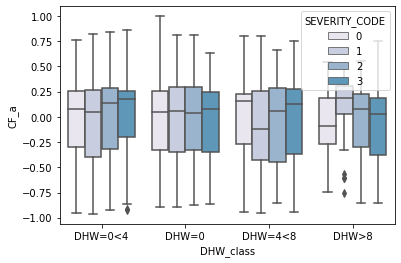

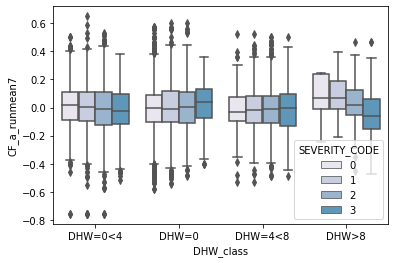

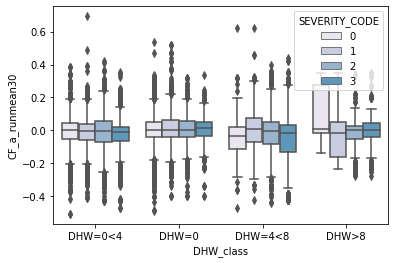

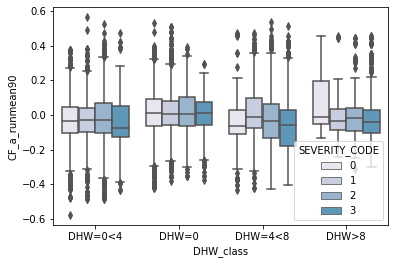

In [13]:
'''
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
import seaborn as sb
import matplotlib.pyplot as plt
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='CF_a', x='DHW_class', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHWboxplot = sb.boxplot(y='CF_a_runmean7', x='DHW_class', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHWboxplot = sb.boxplot(y='CF_a_runmean30', x='DHW_class', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHWboxplot = sb.boxplot(y='CF_a_runmean90', x='DHW_class', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()

In [ ]:
'''
                     Shapiro-Wilks or normaltest 
                      ** test for normality ** 
         each set represent a DHW_class + SEVERITY_CODE + CF_a variable
'''

##### CF #####
stats, p = shapiro(dfDHW0_SC0.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC1.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC2.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC3.CF_a)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW1_4_SC0.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC1.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC2.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC3.CF_a)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW4_8_SC0.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC1.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC2.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC3.CF_a)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW8_SC0.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC1.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC2.CF_a)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC3.CF_a)
print(stats)
print(p)
print("")

###### CFrunmean7 #####

stats, p = shapiro(dfDHW0_SC0.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC1.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC2.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC3.CF_a_runmean7)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW1_4_SC0.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC1.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC2.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC3.CF_a_runmean7)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW4_8_SC0.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC1.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC2.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC3.CF_a_runmean7)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW8_SC0.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC1.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC2.CF_a_runmean7)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC3.CF_a_runmean7)
print(stats)
print(p)
print("")

##### CFrunmean30 #####

stats, p = shapiro(dfDHW0_SC0.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC1.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC2.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC3.CF_a_runmean30)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW1_4_SC0.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC1.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC2.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC3.CF_a_runmean30)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW4_8_SC0.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC1.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC2.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC3.CF_a_runmean30)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW8_SC0.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC1.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC2.CF_a_runmean30)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC3.CF_a_runmean30)
print(stats)
print(p)
print("")

##### runmean90 #####

stats, p = shapiro(dfDHW0_SC0.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC1.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC2.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW0_SC3.CF_a_runmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW1_4_SC0.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC1.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC2.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW1_4_SC3.CF_a_runmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW4_8_SC0.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC1.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC2.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW4_8_SC3.CF_a_runmean90)
print(stats)
print(p)
print("")

stats, p = shapiro(dfDHW8_SC0.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC1.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC2.CF_a_runmean90)
print(stats)
print(p)
print("")
stats, p = shapiro(dfDHW8_SC3.CF_a_runmean90)
print(stats)
print(p)
print("")

In [ ]:
'''
                Levene Test 
       ** test for equal variances ** 
    each test is depending severity code
'''
#### CF ####
stats, p = levene(dfDHW0_SC0.CF_a,dfDHW1_4_SC0.CF_a,dfDHW4_8_SC0.CF_a, dfDHW8_SC0.CF_a)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC1.CF_a,dfDHW1_4_SC1.CF_a,dfDHW4_8_SC1.CF_a, dfDHW8_SC1.CF_a)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC2.CF_a,dfDHW1_4_SC2.CF_a,dfDHW4_8_SC2.CF_a, dfDHW8_SC2.CF_a)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC3.CF_a,dfDHW1_4_SC3.CF_a,dfDHW4_8_SC3.CF_a, dfDHW8_SC3.CF_a)
print(stats)
print(p)
print("")

#### CFrunmean7 ####
stats, p = levene(dfDHW0_SC0.CF_a_runmean7,dfDHW1_4_SC0.CF_a_runmean7,dfDHW4_8_SC0.CF_a_runmean7, dfDHW8_SC0.CF_a_runmean7)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC1.CF_a_runmean7,dfDHW1_4_SC1.CF_a_runmean7,dfDHW4_8_SC1.CF_a_runmean7, dfDHW8_SC1.CF_a_runmean7)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC2.CF_a_runmean7,dfDHW1_4_SC2.CF_a_runmean7,dfDHW4_8_SC2.CF_a_runmean7, dfDHW8_SC2.CF_a_runmean7)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC3.CF_a_runmean7,dfDHW1_4_SC3.CF_a_runmean7,dfDHW4_8_SC3.CF_a_runmean7, dfDHW8_SC3.CF_a_runmean7)
print(stats)
print(p)
print("")

#### CFrunmean30 ####
stats, p = levene(dfDHW0_SC0.CF_a_runmean30,dfDHW1_4_SC0.CF_a_runmean30,dfDHW4_8_SC0.CF_a_runmean30, dfDHW8_SC0.CF_a_runmean30)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC1.CF_a_runmean30,dfDHW1_4_SC1.CF_a_runmean30,dfDHW4_8_SC1.CF_a_runmean30, dfDHW8_SC1.CF_a_runmean30)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC2.CF_a_runmean30,dfDHW1_4_SC2.CF_a_runmean30,dfDHW4_8_SC2.CF_a_runmean30, dfDHW8_SC2.CF_a_runmean30)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC3.CF_a_runmean30,dfDHW1_4_SC3.CF_a_runmean30,dfDHW4_8_SC3.CF_a_runmean30, dfDHW8_SC3.CF_a_runmean30)
print(stats)
print(p)
print("")

#### CFrunmean90 ####
stats, p = levene(dfDHW0_SC0.CF_a_runmean90,dfDHW1_4_SC0.CF_a_runmean90,dfDHW4_8_SC0.CF_a_runmean90, dfDHW8_SC0.CF_a_runmean90)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC1.CF_a_runmean90,dfDHW1_4_SC1.CF_a_runmean90,dfDHW4_8_SC1.CF_a_runmean90, dfDHW8_SC1.CF_a_runmean90)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC2.CF_a_runmean90,dfDHW1_4_SC2.CF_a_runmean90,dfDHW4_8_SC2.CF_a_runmean90, dfDHW8_SC2.CF_a_runmean90)
print(stats)
print(p)
print("")

stats, p = levene(dfDHW0_SC3.CF_a_runmean90,dfDHW1_4_SC3.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90, dfDHW8_SC3.CF_a_runmean90)
print(stats)
print(p)
print("")

In [31]:
'''
                            Kruskal Wallis
    ** Compare if differences between groups of same SEVERITY_CODE **
'''
DHW_class_DHW0_CF_a_Kruskal = stats.kruskal(dfDHW0_SC0.CF_a_runmean90,dfDHW0_SC1.CF_a_runmean90,dfDHW0_SC2.CF_a_runmean90,dfDHW0_SC3.CF_a_runmean90, nan_policy='omit')

DHW_class_DHW1_4_CF_a_Kruskal = stats.kruskal(dfDHW1_4_SC0.CF_a_runmean90,dfDHW1_4_SC1.CF_a_runmean90,dfDHW1_4_SC2.CF_a_runmean90,dfDHW1_4_SC3.CF_a_runmean90, nan_policy='omit')

DHW_class_DHW4_8_CF_a_Kruskal = stats.kruskal(dfDHW4_8_SC0.CF_a_runmean90,dfDHW4_8_SC1.CF_a_runmean90,dfDHW4_8_SC2.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90, nan_policy='omit')

DHW_class_DHW8_CF_a_Kruskal = stats.kruskal(dfDHW8_SC0.CF_a_runmean90,dfDHW8_SC1.CF_a_runmean90,dfDHW8_SC2.CF_a_runmean90,dfDHW8_SC3.CF_a_runmean90, nan_policy='omit')


print(DHW_class_DHW0_CF_a_Kruskal)
print(DHW_class_DHW1_4_CF_a_Kruskal)
print(DHW_class_DHW4_8_CF_a_Kruskal)
print(DHW_class_DHW8_CF_a_Kruskal)

KruskalResult(statistic=0.942609242236538, pvalue=0.815134916249605)
KruskalResult(statistic=17.66103254044082, pvalue=0.0005166321744780716)
KruskalResult(statistic=70.59439997623618, pvalue=3.1839943466324864e-15)
KruskalResult(statistic=8.991204995616881, pvalue=0.02940804974410916)


In [39]:
'''
                          Dunn post_hoc test
          ** Which group is different according to the KW test **
    adjust depending the group to be tested, and print the desired result
'''
#### CF_a_runmean90 ####
DHW_class_DHW0_CF_a_dunn = sp.posthoc_dunn(dfDHW0, 'CFrunmean90', 'SEVERITY_CODE')
DHW_class_DHW1_4_CF_a_dunn = sp.posthoc_dunn(dfDHW1_4, 'CFrunmean90', 'SEVERITY_CODE')
DHW_class_DHW4_8_CF_a_dunn = sp.posthoc_dunn(dfDHW4_8, 'CFrunmean90', 'SEVERITY_CODE')
DHW_class_DHW8_CF_a_dunn = sp.posthoc_dunn(dfDHW8, 'CFrunmean90', 'SEVERITY_CODE') # print this

print('DHW_class_DHW0_CF_a_dunn')
print(DHW_class_DHW0_CF_a_dunn)
print('DHW_class_DHW1_4_CF_a_dunn')
print(DHW_class_DHW1_4_CF_a_dunn)
print('DHW_class_DHW4_8_CF_a_dunn')
print(DHW_class_DHW4_8_CF_a_dunn)
print('DHW_class_DHW8_CF_a_dunn')
print(DHW_class_DHW8_CF_a_dunn)


DHW_class_DHW0_CF_a_dunn
              0             1             2             3
0  1.000000e+00  2.026419e-12  2.189302e-09  1.188006e-06
1  2.026419e-12  1.000000e+00  7.800338e-01  3.112262e-15
2  2.189302e-09  7.800338e-01  1.000000e+00  2.166359e-14
3  1.188006e-06  3.112262e-15  2.166359e-14  1.000000e+00
DHW_class_DHW1_4_CF_a_dunn
              0             1             2             3
0  1.000000e+00  2.138594e-08  6.217483e-01  7.593933e-10
1  2.138594e-08  1.000000e+00  3.639774e-10  3.108115e-25
2  6.217483e-01  3.639774e-10  1.000000e+00  3.850242e-09
3  7.593933e-10  3.108115e-25  3.850242e-09  1.000000e+00
DHW_class_DHW4_8_CF_a_dunn
          0         1         2         3
0  1.000000  0.170036  0.132861  0.000219
1  0.170036  1.000000  0.912048  0.012267
2  0.132861  0.912048  1.000000  0.000191
3  0.000219  0.012267  0.000191  1.000000
DHW_class_DHW8_CF_a_dunn
          0         1         2         3
0  1.000000  0.117167  0.204792  0.089633
1  0.117167  1.000000 

In [12]:
from scipy.stats import f_oneway
aov = f_oneway(dfDHW8_SC0.CF_a_runmean90,dfDHW8_SC1.CF_a_runmean90,dfDHW8_SC2.CF_a_runmean90,dfDHW8_SC3.CF_a_runmean90)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=dfDHW8['CF_a_runmean30'],
                          groups=dfDHW8['SEVERITY_CODE'],
                          alpha=0.05)

print("                     ANOVA             ")
print(aov)
print(" ")
print("                 Tukey post-hoc        ")
print(tukey)

                     ANOVA             
F_onewayResult(statistic=5.068307067266529, pvalue=0.0017411831688345972)
 
                 Tukey post-hoc        
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.1093  0.001 -0.1634 -0.0551   True
     0      2  -0.1008  0.001 -0.1436 -0.0581   True
     0      3  -0.0909  0.001 -0.1315 -0.0503   True
     1      2   0.0084    0.9  -0.033  0.0498  False
     1      3   0.0184 0.6084 -0.0208  0.0575  False
     2      3   0.0099 0.5956 -0.0109  0.0307  False
----------------------------------------------------


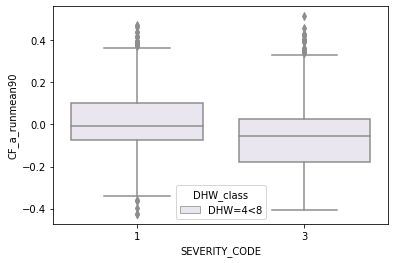

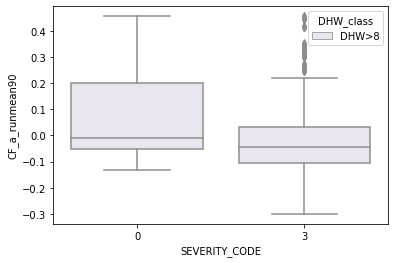

Statistics Mann-Whitney U test dfDHW8_SC0.CF_a,dfDHW8_SC3.CF_a =11252.500, p=0.005
Statistics Mann-Whitney U test dfDHW8_SC0.CF_a_runmean7,dfDHW8_SC3.CF_a_runmean7 =11252.500, p=0.005
Statistics Mann-Whitney U test dfDHW8_SC1.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90 =220360.000, p=0.000
Statistics Mann-Whitney U test dfDHW8_SC0.CF_a_runmean90,dfDHW8_SC3.CF_a_runmean90 =11252.500, p=0.005


In [33]:
'''
         ===    CF's anomaly SEVERITY_CODE 0 vs 3 and DHW_class = DHW8 ===

    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
plot_DHW4_8_SC1vs3 = dfDHW4_8_SC1.append(dfDHW4_8_SC3)
plot_DHW8_SC0vs3=dfDHW8_SC0.append(dfDHW8_SC3)
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
# DHWboxplot = sb.boxplot(y='CF_a', x='SEVERITY_CODE', 
#                  data=plot_DHW8_SC0vs3, 
#                  palette=pal,
#                  hue='DHW_class')
# plt.show()
# DHWboxplot = sb.boxplot(y='CF_a_runmean7', x='SEVERITY_CODE', 
#                  data=plot_DHW8_SC0vs3, 
#                  palette=pal,
#                  hue='DHW_class')
# plt.show()
DHWboxplot = sb.boxplot(y='CF_a_runmean90', x='SEVERITY_CODE', 
                 data=plot_DHW4_8_SC1vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()
DHWboxplot = sb.boxplot(y='CF_a_runmean90', x='SEVERITY_CODE', 
                 data=plot_DHW8_SC0vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()


'''
                        Mann Whitney U-Test     
'''
stat, p = mannwhitneyu(dfDHW8_SC0.CF_a_runmean30,dfDHW8_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC0.CF_a,dfDHW8_SC3.CF_a =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC0.CF_a_runmean30,dfDHW8_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC0.CF_a_runmean7,dfDHW8_SC3.CF_a_runmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW4_8_SC1.CF_a_runmean30,dfDHW4_8_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC1.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC0.CF_a_runmean30,dfDHW8_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC0.CF_a_runmean90,dfDHW8_SC3.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))


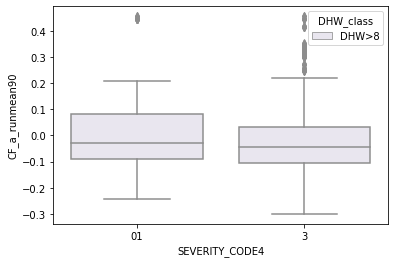

Statistics Mann-Whitney U test dfDHW4_8_SC01.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90 =1394273.500, p=0.001
Statistics Mann-Whitney U test dfDHW4_8_SC01.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90 =396183.000, p=0.000
Statistics Mann-Whitney U test dfDHW8_SC01.CF_a_runmean90,dfDHW8_SC3.CF_a_runmean90 =28867.000, p=0.265


In [34]:
'''
        ===    CF's anomaly SEVERITY_CODE 0 + 1 vs 3 and DHW_class = DHW8 ===
            
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
dfSC0and1 = data[data['SEVERITY_CODE3'] == '01']
dfSC0and1vsSC3 = dfSC0and1.append(dfSC3)
dfSC0and1vsSC3 = dfSC0and1vsSC3[(dfSC0and1vsSC3['DHW_class']=='DHW>8')]
dfSC0and1vsSC3['SEVERITY_CODE4'] = np.where(dfSC0and1vsSC3['SEVERITY_CODE']<=1,"01","3")
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
# DHWboxplot = sb.boxplot(y='CF_a', x='SEVERITY_CODE4', 
#                  data=dfSC0and1vsSC3,
#                  palette=pal,
#                  hue='DHW_class')
# plt.show()
# DHWboxplot = sb.boxplot(y='CF_a_runmean7', x='SEVERITY_CODE4', 
#                  data=dfSC0and1vsSC3,
#                  palette=pal,
#                  hue='DHW_class')
# plt.show()
# DHWboxplot = sb.boxplot(y='CF_a_runmean30', x='SEVERITY_CODE4', 
#                  data=dfSC0and1vsSC3,
#                  palette=pal,
#                  hue='DHW_class')
# plt.show()
DHWboxplot = sb.boxplot(y='CF_a_runmean90', x='SEVERITY_CODE4', 
                 data=dfSC0and1vsSC3,
                 palette=pal,
                 hue='DHW_class')
plt.show()

'''
                        Mann Whitney U-Test   
               CF's SEVERITY_CODE 0 + 1 vs 3 and DHW_class = DHW8           
'''
# stat, p = mannwhitneyu(dfDHW8_SC01.CF_a,dfDHW8_SC3.CF_a)
# print('Statistics Mann-Whitney U test dfDHW8_SC01.CF_a,dfDHW8_SC3.CF_a =%.3f, p=%.3f' % (stat, p))
# stat, p = mannwhitneyu(dfDHW8_SC01.CF_a_runmean7,dfDHW8_SC3.CF_a_runmean7)
# print('Statistics Mann-Whitney U test dfDHW8_SC01.CF_a_runmean7,dfDHW8_SC3.CF_a_runmean7 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW0_4_SC01.CF_a_runmean30,dfDHW1_4_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW4_8_SC01.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW4_8_SC01.CF_a_runmean30,dfDHW4_8_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW4_8_SC01.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC01.CF_a_runmean30,dfDHW8_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC01.CF_a_runmean90,dfDHW8_SC3.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))

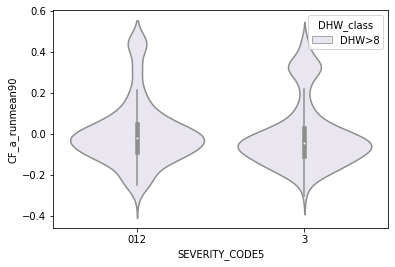

Statistics Mann-Whitney U test dfDHW1_4_SC012.CF_a_runmean90,dfDHW1_4_SC3.CF_a_runmean90 =2175933.000, p=0.001
Statistics Mann-Whitney U test dfDHW4_8_SC012.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90 =1122383.000, p=0.000
Statistics Mann-Whitney U test dfDHW8_SC012.CF_a_runmean90,dfDHW8_SC3.CF_a_runmean90 =99038.500, p=0.237


In [35]:
'''
        ===    CF's anomaly SEVERITY_CODE 0+1+2 vs 3 and DHW_class = DHW8 ===
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
plotDHW8_SC123vs3 = data[data['DHW_class']== 'DHW>8']
#make grouped boxplot
# plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
# DHWboxplot = sb.boxplot(y='CF_a', x='SEVERITY_CODE5', 
#                  data=plotDHW8_SC123vs3, 
#                  palette=pal,
#                  hue='DHW_class')
# plt.show()
# DHWboxplot = sb.boxplot(y='CF_a_runmean7', x='SEVERITY_CODE5', 
#                  data=plotDHW8_SC123vs3, 
#                  palette=pal,
#                  hue='DHW_class')
# plt.show()
# DHWboxplot = sb.boxplot(y='CF_a_runmean30', x='SEVERITY_CODE5', 
#                  data=plotDHW8_SC123vs3, 
#                  palette=pal,
#                  hue='DHW_class')
plt.show()
DHWboxplot = sb.violinplot(y='CF_a_runmean90', x='SEVERITY_CODE5', 
                 data=plotDHW8_SC123vs3, 
                 palette=pal,
                 hue='DHW_class')
plt.show()

'''
                        Mann Whitney U-Test 
            CF's SEVERITY_CODE 0+1+2 vs 3 and DHW_class = DHW8    
'''

stat, p = mannwhitneyu(dfDHW0_4_SC012.CF_a_runmean30,dfDHW1_4_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW1_4_SC012.CF_a_runmean90,dfDHW1_4_SC3.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW4_8_SC012.CF_a_runmean30,dfDHW4_8_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW4_8_SC012.CF_a_runmean90,dfDHW4_8_SC3.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC012.CF_a_runmean30,dfDHW8_SC3.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC012.CF_a_runmean90,dfDHW8_SC3.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))

Statistics Mann-Whitney U test dfDHW8_SC23.CF_a,dfDHW8_SC0.CF_a =2796595.000, p=0.111
Statistics Mann-Whitney U test dfDHW8_SC23.CF_a,dfDHW8_SC0.CF_a =321469.500, p=0.130
Statistics Mann-Whitney U test dfDHW8_SC23.CF_a,dfDHW8_SC0.CF_a =15714.500, p=0.003


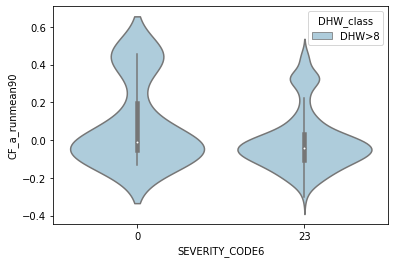

In [36]:
'''
        ===    CF's anomaly SEVERITY_CODE 0 vs 2 + 3 and DHW_class = DHW8 ===
            
    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
dfSC2and3 = data[data['SEVERITY_CODE3'] == '23']
dfSC2and3vsSC0 = dfSC2and3.append(dfSC0)
dfSC2and3vsSC0 = dfSC2and3vsSC0[(dfSC2and3vsSC0['DHW_class']=='DHW>8')]
dfSC2and3vsSC0['SEVERITY_CODE6'] = np.where(dfSC2and3vsSC0['SEVERITY_CODE']>=2,"23","0")
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('Paired')
DHWboxplot = sb.violinplot(y='CF_a_runmean90', x='SEVERITY_CODE6', 
                 data=dfSC2and3vsSC0,
                 palette=pal,
                 hue='DHW_class')

stat, p = mannwhitneyu(dfDHW0_4_SC23.CF_a_runmean90,dfDHW1_4_SC0.CF_a_runmean90)
print('Statistics Mann-Whitney U test dfDHW8_SC23.CF_a,dfDHW8_SC0.CF_a =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW4_8_SC23.CF_a_runmean90,dfDHW4_8_SC0.CF_a_runmean90)
print('Statistics Mann-Whitney U test dfDHW8_SC23.CF_a,dfDHW8_SC0.CF_a =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(dfDHW8_SC23.CF_a_runmean30,dfDHW8_SC0.CF_a_runmean30)
print('Statistics Mann-Whitney U test dfDHW8_SC23.CF_a,dfDHW8_SC0.CF_a =%.3f, p=%.3f' % (stat, p))

In [ ]:
'''
         ===    CF's anomaly SEVERITY_CODE 0 vs 2 and DHW_class = DHW8 ===

    Boxplot (general boxplot Cloud_Cover metrics by SEVERITY_CODE and hue=DHW_class)
'''
plot_DHW8_SC0vs2=dfDHW8_SC0.append(dfDHW8_SC2)
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.violinplot(y='CF_a_runmean90', x='SEVERITY_CODE', 
                 data=plot_DHW8_SC0vs2, 
                 palette=pal,
                 hue='DHW_class')
stat, p = mannwhitneyu(dfDHW8_SC0.CF_a_runmean90,dfDHW8_SC2.CF_a_runmean90)
print('Statistics Mann-Whitney U test dfDHW8_SC0.CF_a_runmean90,dfDHW8_SC2.CF_a_runmean90 =%.3f, p=%.3f' % (stat, p))

# 7. RANDOM_FOREST
## What variables best predicts bleaching severity?

# 8. RANDOM_FOREST 
## Have the best predictors of bleaching severity changed over time?  

# 9-15. Is the effect of cloudiness more evident if we focus on a single event? 

# 16-22. Is late reporting of bleaching a source of error in this analysis?
## ADJUSTED DATE
## repeat all previous steps but for adjusted dates


In [ ]:
'''
    Define dataset(s) for correllogram
    First two datasets for adjusted date 
'''
data_adj = data.loc[:, data.columns.str.contains('adj')] # select only adjusted date
data_adj = data_adj.loc[:, data_dor.columns.str.contains('_a')] # select not anomaly in CF
X = data_adj.drop(['DHW_class','SEVERITY_CODE', 'COUNTRY', 'DAY', 'MONTH','YEAR','JD','lat','lon','full_date','ITEM_ID',], axis=1) # dependent variables
y = data_dor['SEVERITY_CODE'] # labels (indipendent variable)

## How does DHW vary with bleaching severity?

In [ ]:
'''
    Boxplot (general boxplot DHW by SEVERITY per variable)
     ** in this step select the most convenient plot ** 
'''
#make grouped boxplot
#plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='DHW_adj_date', x='SEVERITY_CODE', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHW_adj_dateboxplot = sb.boxplot(y='DHWrunmean7_adj_date', x='SEVERITY_CODE', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHWrunmean30boxplot = sb.boxplot(y='DHWrunmean30_adj_date', x='SEVERITY_CODE', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()
DHWrunmean30_adj_dateboxplot = sb.boxplot(y='DHWrunmean90_adj_date', x='SEVERITY_CODE', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
plt.show()

## Boxplot DHW by YEAR and hue=SEVERITY

In [ ]:
'''
    Boxplot (general boxplot DHW by YEAR and hue=SEVERITY per variable)
'''
import seaborn as sb
import matplotlib.pyplot as plt
#make grouped boxplot
plt.figure(figsize=(18,10))
pal = sb.color_palette('PuBu')
DHWboxplot = sb.boxplot(y='CF_a_runmean90', x='YEAR', 
                 data=data, 
                 palette=pal,
                 hue='SEVERITY_CODE')
#plt.show()
## make grouped stripplot
# DHWstripplot = sb.stripplot(y='CFrunmean7', x='YEAR', 
#                    hue='SEVERITY_CODE',
#                    data=data, 
#                    jitter=True,
#                    dodge=True, 
#                    marker='o', 
#                    alpha=0.25,
#                    size=2.5,
#                    split=True,
#                    palette=pal,
#                    linewidth=0.5)
# # get legend information from the plot object
# handles, labels = DHWstripplot.get_legend_handles_labels()
# # specify just one legend
# l = plt.legend(handles[0:4], labels[0:4])
#plt.savefig('DHWboxplot.pdf', dpi=300)
plt.show()

In [ ]:
'''
Create individial df per SEVERITY_CODE per variable
''' 
SC0_DHW = dfSC0['DHW']
SC1_DHW = dfSC1['DHW']
SC2_DHW = dfSC2['DHW']
SC3_DHW = dfSC3['DHW']
SC0_DHW_adj = dfSC0['DHW_adj_date']
SC1_DHW_adj = dfSC1['DHW_adj_date']
SC2_DHW_adj = dfSC2['DHW_adj_date']
SC3_DHW_adj = dfSC3['DHW_adj_date']
SC0_CF_7 = dfSC0['CFrunmean7']
SC1_CF_7 = dfSC1['CFrunmean7']
SC2_CF_7 = dfSC2['CFrunmean7']
SC3_CF_7 = dfSC3['CFrunmean7']
SC0_CF_7_adj = dfSC0['CFrunmean7_adj_date']
SC1_CF_7_adj = dfSC1['CFrunmean7_adj_date']
SC2_CF_7_adj = dfSC2['CFrunmean7_adj_date']
SC3_CF_7_adj = dfSC3['CFrunmean7_adj_date']
SC0_CF_30 = dfSC0['CFrunmean30']
SC1_CF_30 = dfSC1['CFrunmean30']
SC2_CF_30 = dfSC2['CFrunmean30']
SC3_CF_30 = dfSC3['CFrunmean30']

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
list_df_severity = (dfDHW0_SC0,dfDHW0_SC1,dfDHW0_SC2,dfDHW0_SC3)
pal = sb.color_palette('PuBu')
for item in list_df_severity:
    #plt.figure(figsize=(18,10))
    plot=sb.boxplot(y='CFrunmean90_adj_date', x='SEVERITY_CODE',
                 data=item, 
                 palette=pal) 
                 #alpha=0.5)
    plt.show()

In [ ]:
print(dfDHW8_SC0.CFrunmean7_adj_date.describe())
print(dfDHW8_SC3.CFrunmean7_adj_date.describe())

In [ ]:
table = pd.pivot_table(data, values=['DHW_9','DHW_9_adj_date'], index=['YEAR','SEVERITY_CODE'],
                    aggfunc={'DHW_9': np.mean,
                    'DHW_9_adj_date': np.mean})

In [ ]:
# DHW plot SC0
plt.figure(figsize=(18,10))
pal = sb.color_palette('viridis')
DHWboxplot = sb.boxplot(y='DHW', x='YEAR', 
                 data=dfSC0,
                 palette=pal)
reference = [0]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='r', linestyles='--')
reference = [4]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='b', linestyles='--')
reference = [8]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='g', linestyles='--')
## make grouped stripplot
DHWstripplot = sb.stripplot(y='DHW', x='YEAR', 
                   data=dfSC0, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.25,
                   size=2.5,
                   split=True,
                   linewidth=0.5,
                   color='black')
plt.show()

# DHW plot SC1
plt.figure(figsize=(18,10))
pal = sb.color_palette('viridis')
DHWboxplot = sb.boxplot(y='DHW', x='YEAR', 
                 data=dfSC1,
                 palette=pal)
reference = [0, 4]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='r', linestyles='--')
## make grouped stripplot
DHWstripplot = sb.stripplot(y='DHW', x='YEAR', 
                   data=dfSC1, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.25,
                   size=2.5,
                   split=True,
                   linewidth=0.5,
                   color='black')
plt.show()

# DHW plot SC2
plt.figure(figsize=(18,10))
pal = sb.color_palette('viridis')
DHWboxplot = sb.boxplot(y='DHW', x='YEAR', 
                 data=dfSC2,
                 palette=pal)
reference = [4, 8]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='r', linestyles='--')
## make grouped stripplot
DHWstripplot = sb.stripplot(y='DHW', x='YEAR', 
                   data=dfSC2, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.25,
                   size=2.5,
                   split=True,
                   linewidth=0.5,
                   color='black')
plt.show()

# DHW plot SC3
plt.figure(figsize=(18,10))
pal = sb.color_palette('viridis')
DHWboxplot = sb.boxplot(y='DHW', x='YEAR', 
                 data=dfSC3,
                 palette=pal)
reference = [8, 16]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='r', linestyles='--')
## make grouped stripplot
DHWstripplot = sb.stripplot(y='DHW', x='YEAR', 
                   data=dfSC3, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.25,
                   size=2.5,
                   split=True,
                   linewidth=0.5,
                   color='black')
plt.show()

In [ ]:
### cloud plot SC0
plt.figure(figsize=(18,10))
pal = sb.color_palette('viridis')
DHWboxplot = sb.boxplot(y='CF_runmean30', x='YEAR', 
                 data=dfSC0,
                 palette=pal)
reference = [0]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='red', linestyles='-')
reference = [0.0059,0.395]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='orange', linestyles='-')
reference = [0.4,0.595]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='yellow', linestyles='-')
reference = [0.6,0.995]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='green', linestyles='-')
reference = [1]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='blue', linestyles='-')
## make grouped stripplot
DHWstripplot = sb.stripplot(y='CF_runmean30', x='YEAR', 
                   data=dfSC0, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.25,
                   size=2.5,
                   split=True,
                   linewidth=0.5,
                   color='black')
plt.show()

### cloud plot SC1
plt.figure(figsize=(18,10))
pal = sb.color_palette('viridis')
DHWboxplot = sb.boxplot(y='CF_runmean30', x='YEAR', 
                 data=dfSC1,
                 palette=pal)
reference = [0, 0.1]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='red', linestyles='-')
reference = [0.1,0.395]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='orange', linestyles='-')
reference = [0.4,0.595]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='yellow', linestyles='-')
reference = [0.6,0.995]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='green', linestyles='-')
reference = [1]                 
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color='blue', linestyles='-')
## make grouped stripplot
DHWstripplot = sb.stripplot(y='CF_runmean30', x='YEAR', 
                   data=dfSC1, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.25,
                   size=2.5,
                   split=True,
                   linewidth=0.5,
                   color='black')
plt.show()

In [ ]:
# Create an Histogram per variable per severity code
DHW_by_severity = (dfSC0[['DHW']],dfSC1[['DHW']],dfSC2[['DHW']],dfSC3[['DHW']])
CF_Rmean_14_by_severity = (dfSC0[['CF_Rmean_14']],dfSC1[['CF_Rmean_14']],dfSC2[['CF_Rmean_14']],dfSC3[['CF_Rmean_14']])
for item in DHW_by_severity:
    histogram = item.hist()
    print(histogram)
for item in CF_Rmean_14_by_severity:
    histogram = item.hist()
    print(histogram)
# dfSC0[['DHW']].hist()
# dfSC1[['DHW']].hist()
# dfSC2[['DHW']].hist()
# dfSC3[['DHW']].hist()

In [ ]:
# Shapiro-Wilk Normality Test
from scipy.stats import shapiro

## DHW
stat, p = shapiro(SC0_DHW)
print('stat=%.3f, p=%.3f' % (stat, p))
stat, p = shapiro(SC1_DHW)
print('stat=%.3f, p=%.3f' % (stat, p))
stat, p = shapiro(SC2_DHW)
print('stat=%.3f, p=%.3f' % (stat, p))
stat, p = shapiro(SC3_DHW)
print('stat=%.3f, p=%.3f' % (stat, p))
print(' ')
# ## CF_14
# stat, p = shapiro(SC0_CF_14)
# print('stat=%.3f, p=%.3f' % (stat, p))
# stat, p = shapiro(SC1_CF_14)
# print('stat=%.3f, p=%.3f' % (stat, p))
# stat, p = shapiro(SC2_CF_14)
# print('stat=%.3f, p=%.3f' % (stat, p))
# stat, p = shapiro(SC3_CF_14)
# print('stat=%.3f, p=%.3f' % (stat, p))
# print(' ')
# ## CF_30
# stat, p = shapiro(SC0_CF_30)
# print('stat=%.3f, p=%.3f' % (stat, p))
# stat, p = shapiro(SC1_CF_30)
# print('stat=%.3f, p=%.3f' % (stat, p))
# stat, p = shapiro(SC2_CF_30)
# print('stat=%.3f, p=%.3f' % (stat, p))
# stat, p = shapiro(SC3_CF_30)
print('stat=%.3f, p=%.3f' % (stat, p))

In [ ]:
# Mann Whitney U-Test CF_7's
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(SC0_CF_7, SC1_CF_7)
print('Statistics Mann-Whitney U test CF_70_1 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC0_CF_7, SC2_CF_7)
print('Statistics Mann-Whitney U test CF_70_2 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC0_CF_7, SC3_CF_7)
print('Statistics Mann-Whitney U test CF_70_3 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC1_CF_7, SC2_CF_7)
print('Statistics Mann-Whitney U test CF_71_2 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC1_CF_7, SC3_CF_7)
print('Statistics Mann-Whitney U test CF_71_3 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC2_CF_7, SC3_CF_7)
print('Statistics Mann-Whitney U test CF_72_3 =%.3f, p=%.3f' % (stat, p))

In [ ]:
# Mann Whitney U-Test CF_30's
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(SC0_CF_30, SC1_CF_30)
print('Statistics Mann-Whitney U test CF_30_0_1 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC0_CF_30, SC2_CF_30)
print('Statistics Mann-Whitney U test CF_30_0_2 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC0_CF_30, SC3_CF_30)
print('Statistics Mann-Whitney U test CF_30_0_3 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC1_CF_30, SC2_CF_30)
print('Statistics Mann-Whitney U test CF_30_1_2 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC1_CF_30, SC3_CF_30)
print('Statistics Mann-Whitney U test CF_30_1_3 =%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(SC2_CF_30, SC3_CF_30)
print('Statistics Mann-Whitney U test CF_30_2_3 =%.3f, p=%.3f' % (stat, p))

In [ ]:
# Make boxplot by cloud fraction level
import seaborn as sb
import matplotlib.pyplot as plt
CFSC_30_7boxplot = sb.boxplot(y='CF_Rmean_30_7', x='SEVERITY_CODE', 
                 data=data, 
                 palette="PuBu")
plt.show()
plt.figure(figsize=(20,10))
CF_30_7boxplot = sb.boxplot(y='CF_Rmean_30_7', x='YEAR', 
                 data=data, 
                 palette="PuBu",
                 hue='SEVERITY_CODE')
# sb.stripplot(y='CF_Rmean_30_7', x='YEAR', 
#                    data=data, 
#                    jitter=0.1,
#                    dodge=True, 
#                    marker='o', 
#                    alpha=0.20,
#                    size=2.5,
#                    color='black')
plt.show()

In [ ]:
# Histograms
import matplotlib.pyplot as plt
import pylab as pl
data[['DHW']].hist(bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
#plt.savefig('DHW_hist.pdf', dpi=300)
data[['DHW_adj_date']].hist()
#plt.savefig('DAMMM_hist.pdf', dpi=300)
(plt.show())

In [ ]:
# Stacked histograms
import matplotlib.pyplot as plt
import pylab as pl
colors = ['red', 'orange', 'yellow']
data.pivot(columns='SEVERITY_CODE').DHW.plot(kind = 'hist', stacked=True, cmap='winter',bins=[0,4,8,16])
#plt.savefig('DHW_stackedhist.pdf', dpi=300)
data.pivot(columns='SEVERITY_CODE').DHW_9.plot(kind = 'hist', stacked=True, cmap='winter')
#plt.savefig('DAMMM_stackedhist.pdf', dpi=300)
data.pivot(columns='SEVERITY_CODE').DHWrunmean7.plot(kind = 'hist', stacked=True, cmap='winter', bins=[0,.25,.5,.75,1])
#plt.savefig('CF_runmean60_stackedhist.pdf', dpi=300)
data.pivot(columns='SEVERITY_CODE').DHWrunmean30.plot(kind = 'hist', stacked=True, cmap='winter')
#plt.savefig('SST_RMax60_stackedhist.pdf', dpi=300)
(plt.show())

In [ ]:
# Pairplots 
# Create individial series per variable and severity 
import seaborn as sb
import matplotlib.pyplot as plt
Cf_DHW = data[['CFrunmean30','DHW','SEVERITY_CODE']]
pairgrid = sb.pairplot(Cf_DHW,hue='SEVERITY_CODE',palette="YlGnBu", kind='reg', markers='.', corner=True, plot_kws={'scatter_kws':{'alpha': 0.6,'edgecolor': 'none'}},size = 6)
#plt.savefig('pairplotDHW_CFD30.pdf', dpi=300)